# <font color="orange">Apple LLM</font>
A simple **LLM** that can answer simple questions about apple fruit, based on a **decoder-only** transformer model.

# clone from github

Clone the project directory from GitHub.

In [62]:
!git clone http://github.com/gitFarzam/llm

fatal: destination path 'llm' already exists and is not an empty directory.


Open the text file and print the first 500 characters.

In [63]:
text = open('llm/apple/apple.txt' , 'r').read()
print(text[:500])

Is an apple nutritious? Yes, apples are nutritious.
Do apples contain fiber? Yes, apples have fiber.
What vitamins are in apples? Apples have vitamin C.
Are apples good for health? Yes, apples are healthy.
Is apple a healthy fruit? Yes, very healthy.
Does apple aid digestion? Yes, fiber aids digestion.
Do apples help immunity? Yes, vitamin C helps.
Are apples low in calories? Yes, low in calories.
Do apples have antioxidants? Yes, rich in antioxidants.
Can apples improve heart health? Yes, good 


In [64]:
# convert all the words to lowercase. (now Apple=apple , Fruit=fruit , ...)
text = text.lower()

# <b>Import Libraries</b>

In [65]:
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# <b> Tokenization </b>

## create chunks sequences
replace `?` with `EOS` and check is there any `apple` word in the sentences, also clear punctuations.

> `EOS` indicates the end of a sentence, helping for model training purposes.

In [66]:
eos_token = 'EOS'

In [67]:
chunks = [
    i.\
    replace('?',f' {eos_token}').\
    replace(',','').\
    replace("'","")\
    for i in text.split('.') if 'apple' in i
    ]
len(chunks) , chunks[:2]

(558,
 ['is an apple nutritious EOS yes apples are nutritious',
  '\ndo apples contain fiber EOS yes apples have fiber'])

## tokenization using `nltk`

In [68]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [69]:
tokens = [i for i in set(nltk.tokenize.word_tokenize("".join(chunks)))]
tokens.append('PAD')
# just note, when the batch size is 1, padding is unnecessary. However, if the batch size is greater than 1,
# padding becomes necessary because tensors need to be the same size to stack on each other.
len(tokens) , tokens[:10]

(185,
 ['promote',
  'dietary',
  'well',
  'hair',
  'effects',
  'gums',
  'fruit',
  'sugars',
  'contain',
  'elderly'])

## covert each chunk to a sequence (tokenization)

In [70]:
chunks_seq = [chunk.split() for chunk in chunks]
chunks_seq[:2]

[['is',
  'an',
  'apple',
  'nutritious',
  'EOS',
  'yes',
  'apples',
  'are',
  'nutritious'],
 ['do', 'apples', 'contain', 'fiber', 'EOS', 'yes', 'apples', 'have', 'fiber']]

## add identifier

In [71]:
id_to_token = {id:token for id,token in enumerate(tokens)}
token_to_id = {token:id for id,token in enumerate(tokens)}
id_to_token[22] , token_to_id['apple'], token_to_id[eos_token], token_to_id['PAD']

('they', 98, 134, 184)

# Initializing

In [72]:
batch_size=1
seq_len = max([len(seq) for seq in chunks_seq])
num_tokens = len(tokens)
dmodel = 32
dropout = 0. # it's unneccessary for a simple dataset like this.
print(f"batch_size:{batch_size} | seq_len:{seq_len} | num_tokens:{num_tokens} | dmodel:{dmodel} | dropout:{dropout}")

batch_size:1 | seq_len:12 | num_tokens:185 | dmodel:32 | dropout:0.0


In [73]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Dataset and DataLoader

Just for fun let's observe how each token in every sequence will be replaced by its corresponding token id.

In [74]:
chunck_to_int = [[token_to_id[token] for token in chunk] for chunk in chunks_seq]
chunck_to_int[:5]

[[10, 27, 98, 154, 134, 173, 86, 145, 154],
 [74, 86, 8, 91, 134, 173, 86, 157, 91],
 [20, 23, 145, 13, 86, 134, 86, 157, 88, 139],
 [145, 86, 114, 47, 79, 134, 173, 86, 145, 90],
 [10, 98, 125, 90, 6, 134, 173, 92, 90]]

## create dataset

In [75]:
class AppleDataset(Dataset):
  def __init__(self,chunks_seq):
    self.chunks_seq = [[token_to_id[token] for token in chunk] for chunk in chunks_seq]

  def __len__(self):
    return len(self.chunks_seq)

  def __getitem__(self, index) :
    input = torch.tensor(self.chunks_seq[index])
    label = torch.concatenate((torch.tensor(self.chunks_seq[index])[1:] , torch.tensor([token_to_id[eos_token]])))

    return input,label

dataset = AppleDataset(chunks_seq)
dataset[0] # get the first index (input and label)

(tensor([ 10,  27,  98, 154, 134, 173,  86, 145, 154]),
 tensor([ 27,  98, 154, 134, 173,  86, 145, 154, 134]))

In [76]:
num_samples = len(dataset)
num_samples

558

## test how padding function works with a test tensor.

In [77]:
tensors = [dataset[0][0] , dataset[1][0]  , dataset[2][0]]
tensors

[tensor([ 10,  27,  98, 154, 134, 173,  86, 145, 154]),
 tensor([ 74,  86,   8,  91, 134, 173,  86, 157,  91]),
 tensor([ 20,  23, 145,  13,  86, 134,  86, 157,  88, 139])]

In [78]:
def padding(t):
  return F.pad(t,pad=(0,seq_len-len(t)),value=token_to_id["PAD"],mode='constant')

# We will use the map function to add padding to all tensors.
# Additionally, by using stack, we can automatically convert a list of tensors into a stacked version.
stacked_tensors = torch.stack(list(map(padding,tensors)))
stacked_tensors

tensor([[ 10,  27,  98, 154, 134, 173,  86, 145, 154, 184, 184, 184],
        [ 74,  86,   8,  91, 134, 173,  86, 157,  91, 184, 184, 184],
        [ 20,  23, 145,  13,  86, 134,  86, 157,  88, 139, 184, 184]])

## create dataloader object and add padding using `collate_fn`

also [here](https://datascience.stackexchange.com/questions/114244/multi-head-self-attention-output-size-for-batches-with-different-sequence-length) is mentioned, about `bucketting` instead of padding

In [79]:
def add_padding(batch):
  def padding(t):
    return F.pad(t,pad=(0,seq_len-len(t)),value=token_to_id["PAD"],mode='constant')

  inputs=[]
  labels=[]
  for i in batch:
    inputs.append(i[0])
    labels.append(i[1])

  return torch.stack(list(map(padding,inputs))) , torch.stack(list(map(padding,labels)))


train_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=add_padding)# again, padding was unneccessary here, because batch size is 1
# however we may use it when the batch size is bigger than 1!
next(iter(train_loader))

(tensor([[ 10,  27,  98, 154, 134, 173,  86, 145, 154, 184, 184, 184]]),
 tensor([[ 27,  98, 154, 134, 173,  86, 145, 154, 134, 184, 184, 184]]))

# <b>Positional Encoding</b>

In [80]:
class PositionalEncoding(nn.Module):
  def __init__(self,dmodel,seq_len,dropout:float):
    super().__init__()

    pe = torch.zeros((seq_len,dmodel))

    position = torch.arange(0, seq_len, step=1).float().unsqueeze(1)

    embedding_index = torch.arange(0, dmodel, 2).float()

    div_term = 1/((torch.tensor(10000.0)**(embedding_index/dmodel)))

    pe[:, 0::2] = torch.sin(position*div_term)
    pe[:, 1::2] = torch.cos(position*div_term)

    self.dropout = nn.Dropout(dropout)
    self.register_buffer('pe' , pe)


  def forward(self,input_we):
    self.pe = self.pe
    input_we + self.pe[:input_we.size(0) , :]
    return self.dropout(input_we + self.pe[:input_we.size(0) , :])


# <b>Attention</b>

In [81]:
class Attention(nn.Module):
  def __init__(self,dmodel ):
    super().__init__()

    self.wq = nn.Linear(dmodel,dmodel)
    self.wk = nn.Linear(dmodel,dmodel)
    self.wv = nn.Linear(dmodel,dmodel)

  def forward(self,pe_q,pe_k:torch.Tensor,pe_v,mask=None):
    q = self.wq(pe_q)
    k = self.wk(pe_k)
    v = self.wv(pe_v)
    sc_normalized = torch.matmul(q,k.T)/(pe_k.shape[0]**0.5)

    if mask is not None:
      sc_normalized = torch.masked_fill(sc_normalized , mask , -1e9)

    softmax_output = F.softmax(sc_normalized , dim=1)
    attention_value = torch.matmul(softmax_output,v)

    return attention_value



# Decoder-Only object

In [82]:
class DecoderOnly(nn.Module):
  def __init__(self,dmodel,num_tokens,seq_len,dropout:float,device=device):
    super().__init__()

    self.wembedding = nn.Embedding(num_embeddings=num_tokens , embedding_dim=dmodel)
    self.pencoding = PositionalEncoding(dmodel,seq_len,dropout)
    self.attention = Attention(dmodel)
    self.fc1 = nn.Linear(dmodel,num_tokens)
    self.dropout = nn.Dropout(dropout)

  def forward(self,input):
    we = self.wembedding(input)
    pe = self.pencoding(we)

    mask = torch.tril(torch.ones(size=(input.shape[0], input.shape[0]))).to(device)
    mask = mask == 0

    residual_connection = self.attention(pe,pe,pe,mask=mask) + pe
    output = self.fc1(residual_connection)

    return self.dropout(output)


model = DecoderOnly(dmodel,num_tokens,seq_len,dropout)
model.to(device) # Send model to device

DecoderOnly(
  (wembedding): Embedding(185, 32)
  (pencoding): PositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (attention): Attention(
    (wq): Linear(in_features=32, out_features=32, bias=True)
    (wk): Linear(in_features=32, out_features=32, bias=True)
    (wv): Linear(in_features=32, out_features=32, bias=True)
  )
  (fc1): Linear(in_features=32, out_features=185, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [83]:
next(model.parameters()).device # Check parameters device

device(type='cuda', index=0)

# <b>Build required function</b>

In [84]:
def accuracy(labels,outputs,batch_size):
  targets = torch.argmax(outputs, dim=1)

  return sum(torch.eq(labels , targets))/batch_size

In [85]:
optimizer = SGD(lr=0.01, params=model.parameters())
loss_fn = nn.CrossEntropyLoss()

# <b>Train the model </b>

In [86]:
def train(epochs):
  loss_history = []
  accuracy_history = []
  for epoch in range(epochs):
    loss_epoch = 0
    accuracy_epoch = 0
    for batch_num , data in enumerate(train_loader):
      input, label = data

      # as input, label come from dataloader, they have 1 dim more (because of applying batch size)
      input = input.squeeze(dim=0)
      label = label.squeeze(dim=0)

      # send to the gpu if it is available
      input = input.to(device)
      label = label.to(device)
      # print(f"input:{input} | label:{label}")
      # print(f"label.shape: {label.shape}")

      output = model(input)
      loss = loss_fn(output,label)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_epoch+=loss.detach().item()
      accuracy_epoch+=accuracy(label,output,1)/seq_len


    # print(f"label.shape: {label.shape} | output.shape: {output.shape}")
    if epoch % 10 == 0:
      print(f"epoch: {epoch} | loss: {loss_epoch/num_samples:.4f} | acc: %{(accuracy_epoch/num_samples).cpu()*100:.2f}")

      # print(f"output:\n{output}")
    loss_history.append(loss_epoch/num_samples) # it's better to calculate loss for each sample to have an understandable mesaurement
    accuracy_history.append((accuracy_epoch/num_samples).cpu())
  return loss_history , accuracy_history

loss_history , accuracy_history = train(
  epochs=200
)


epoch: 0 | loss: 2.8373 | acc: %48.61
epoch: 10 | loss: 1.2194 | acc: %68.64
epoch: 20 | loss: 0.9831 | acc: %72.60
epoch: 30 | loss: 0.8538 | acc: %74.93
epoch: 40 | loss: 0.7779 | acc: %76.18
epoch: 50 | loss: 0.7276 | acc: %77.06
epoch: 60 | loss: 0.6888 | acc: %77.70
epoch: 70 | loss: 0.6557 | acc: %78.63
epoch: 80 | loss: 0.6351 | acc: %78.99
epoch: 90 | loss: 0.6194 | acc: %79.18
epoch: 100 | loss: 0.6062 | acc: %79.32
epoch: 110 | loss: 0.5962 | acc: %79.58
epoch: 120 | loss: 0.5805 | acc: %80.02
epoch: 130 | loss: 0.5672 | acc: %80.42
epoch: 140 | loss: 0.5566 | acc: %80.78
epoch: 150 | loss: 0.5475 | acc: %80.94
epoch: 160 | loss: 0.5394 | acc: %81.17
epoch: 170 | loss: 0.5326 | acc: %81.44
epoch: 180 | loss: 0.5272 | acc: %81.57
epoch: 190 | loss: 0.5227 | acc: %81.65


Text(0.5, 1.0, 'loss history per sample')

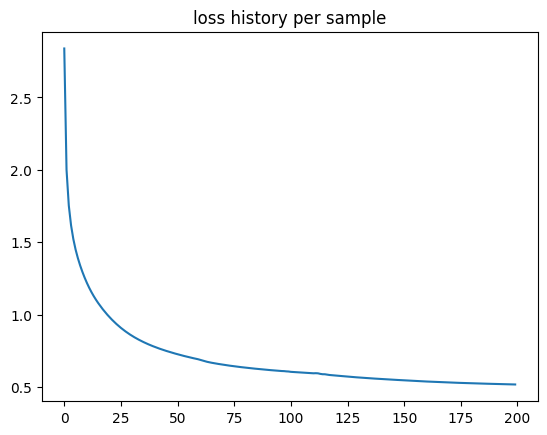

In [87]:
plt.plot(loss_history)
plt.title('loss history per sample')

Text(0.5, 1.0, 'accuracy per predicted token (not whole sentence)')

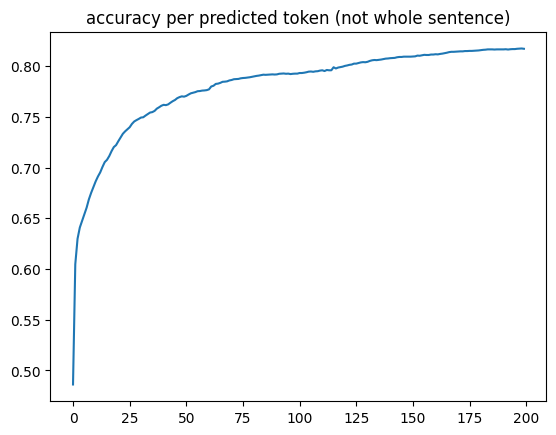

In [88]:
plt.plot(accuracy_history);
plt.title('accuracy per predicted token (not whole sentence)')

In [105]:
def prediction(input , initial_input_len):
  output = model(input)
  predictions = torch.argmax(output , dim=1)[-1].unsqueeze(0)
  # print(f"predictions: {predictions}")
  input = torch.concatenate((input , predictions) , dim=0)

  for i in range(seq_len-initial_input_len-1):
    output = model(input)
    last_token = torch.argmax(output , dim=1)[-1]
    input = torch.concatenate((input , last_token.unsqueeze(0)) , dim=0)
    # print(f'updated input {input}')
    # print(f"last token {last_token.unsqueeze(0)}")
    predictions = torch.concatenate((predictions, last_token.unsqueeze(0)) , dim=0)
    # print(f"predictions {predictions}")

    if last_token.item() == token_to_id['EOS']:
      break

  return predictions


Ask some questions

In [114]:
def ask(questions):

  for q in questions:
    question = q.lower() + " EOS"
    question_tokenized = question.split()

    input_sample = torch.tensor( [token_to_id[token] for token in question_tokenized],device=device)

    output = prediction(input_sample, input_sample.shape[0])
    # print(output)

    print(
        question, "? ",
        " ".join([id_to_token[i.item()] for i in output]),
        print('-----------')
    )

questions = ['Is apple good for skin' , 'Is apple healthy','apple']
ask(questions)

-----------
is apple good for skin EOS ?  yes they do EOS None
-----------
is apple healthy EOS ?  yes very healthy EOS None
-----------
apple EOS ?  yes very brain EOS None
